In [1]:
# Basics
import korean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
import pprint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

Hangul set complete in your Windows!


## Kurly_EDA

---

### 전반적인 전처리

In [2]:
df_review = pd.read_csv('./df_review.csv', encoding='utf-8')
df_review.head(1)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,91a5ff49-71a1-4f51-93ce-cbdaa6fbeae9,심형보,https://play-lh.googleusercontent.com/a/ACg8ocIpio9IlUNq_d9QnvIBNO59jF9eXW7ZZE_luzTk1PDa=mo,빠른배송 좋아요,5,0,3.17.3,2023-09-09 07:49:59,NaN,NaN,3.17.3


In [3]:
# 기본 통계 확인
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14824 entries, 0 to 14823
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              14824 non-null  object
 1   userName              14824 non-null  object
 2   userImage             14824 non-null  object
 3   content               14824 non-null  object
 4   score                 14824 non-null  int64 
 5   thumbsUpCount         14824 non-null  int64 
 6   reviewCreatedVersion  13967 non-null  object
 7   at                    14824 non-null  object
 8   replyContent          14408 non-null  object
 9   repliedAt             14408 non-null  object
 10  appVersion            13967 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.2+ MB


In [4]:
print(df_review.isnull().sum())

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    857
at                        0
replyContent            416
repliedAt               416
appVersion              857
dtype: int64


In [5]:
df_review.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [6]:
# 어플 버전 (서비스 업데이트 전후 확인)
print(len(df_review['reviewCreatedVersion'].unique()))
print(len(df_review['appVersion'].unique()))
print(df_review['reviewCreatedVersion'].equals(df_review['appVersion']))


164
164
True


In [7]:
# 불필요 컬럼 삭제
df_review = df_review.drop(columns=['userImage', 'reviewCreatedVersion'])
df_review.head(1)

,reviewId,userName,content,score,thumbsUpCount,at,replyContent,repliedAt,appVersion
0,91a5ff49-71a1-4f51-93ce-cbdaa6fbeae9,심형보,빠른배송 좋아요,5,0,2023-09-09 07:49:59,NaN,NaN,3.17.3


In [8]:
# 긍정, 부정 리뷰 분류
df_review['sentiment'] = df_review['score'].apply(lambda x: 'Positive' if x >= 4 else 'Negative')

In [9]:
# 기본 통계 확인
print(df_review['score'].describe())

count    14824.000000
mean         4.347477
std          1.277867
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: score, dtype: float64


In [10]:
positive_reviews = df_review[df_review['sentiment'] == 'Positive']
negative_reviews = df_review[df_review['sentiment'] == 'Negative']

positive_reply_ratio = positive_reviews['replyContent'].notna().sum() / len(positive_reviews) * 100
negative_reply_ratio = negative_reviews['replyContent'].notna().sum() / len(negative_reviews) * 100

print(f"긍정 리뷰 중 답글이 달린 비율: {positive_reply_ratio:.2f}%")
print(f"부정 리뷰 중 답글이 달린 비율: {negative_reply_ratio:.2f}%")

긍정 리뷰 중 답글이 달린 비율: 97.83%
부정 리뷰 중 답글이 달린 비율: 93.73%


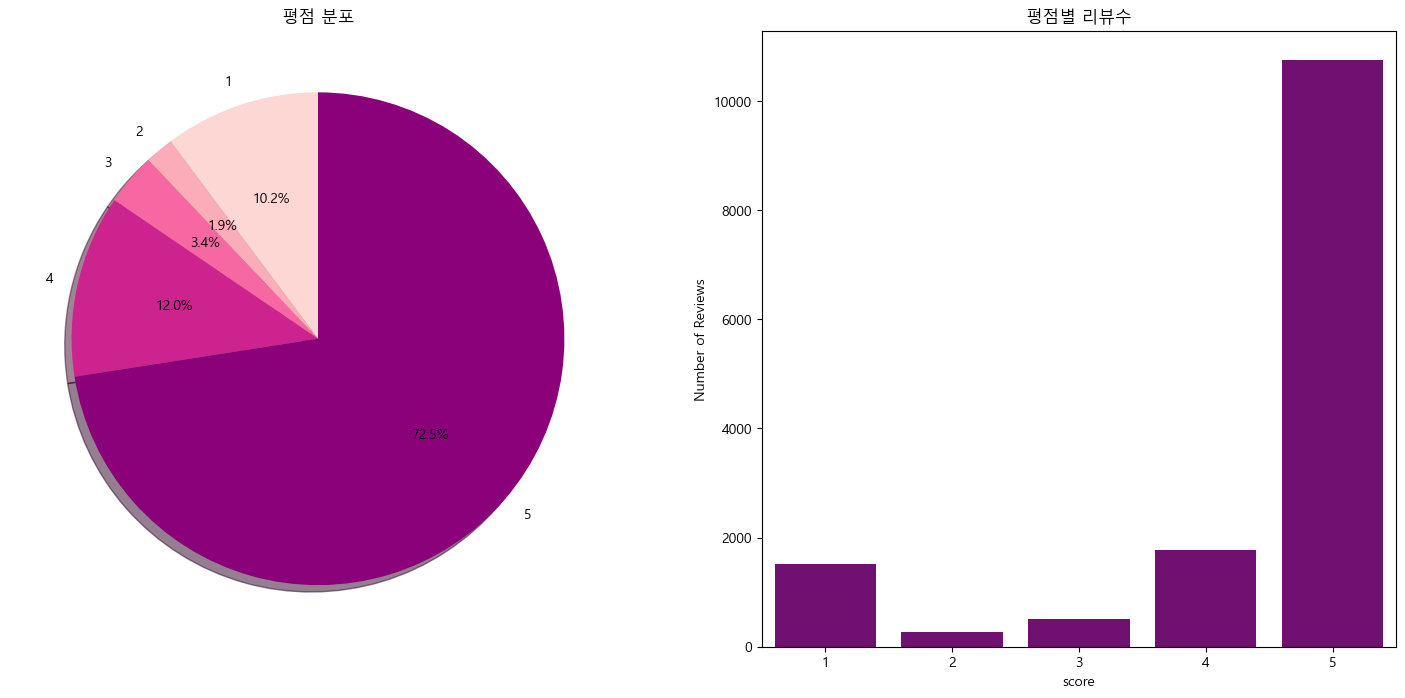

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18,8))

# 파이 차트
df_review['score'].value_counts().sort_index().plot.pie(ax=ax[0], autopct='%1.1f%%', shadow=True, startangle=90, colors=sns.color_palette("RdPu", 5))
ax[0].set_title('평점 분포')
ax[0].set_ylabel('')

# 바 차트
sns.countplot(x='score', data=df_review, ax=ax[1], color='purple', order = df_review['score'].value_counts().sort_index().index)
ax[1].set_title('평점별 리뷰수')
ax[1].set_ylabel('Number of Reviews')

plt.show()


---

### 시계열 시각화

In [12]:
df_review['at'] = pd.to_datetime(df_review['at'])

df_review['year'] = df_review['at'].dt.year
df_review['year_month'] = df_review['at'].dt.to_period('M')
df_review['month'] = df_review['at'].dt.month
df_review['week'] = df_review['at'].dt.weekday
df_review['day'] = df_review['at'].dt.day
df_review['date'] = df_review['at'].dt.date
df_review['hour'] = df_review['at'].dt.hour

In [13]:
df_review[['month', 'week', 'day']]

,month,week,day
0,9,5,9
1,9,5,9
2,9,4,8
3,9,4,8
4,9,4,8
...,...,...,...
14819,3,2,2
14820,3,2,2
14821,3,2,2
14822,3,1,1


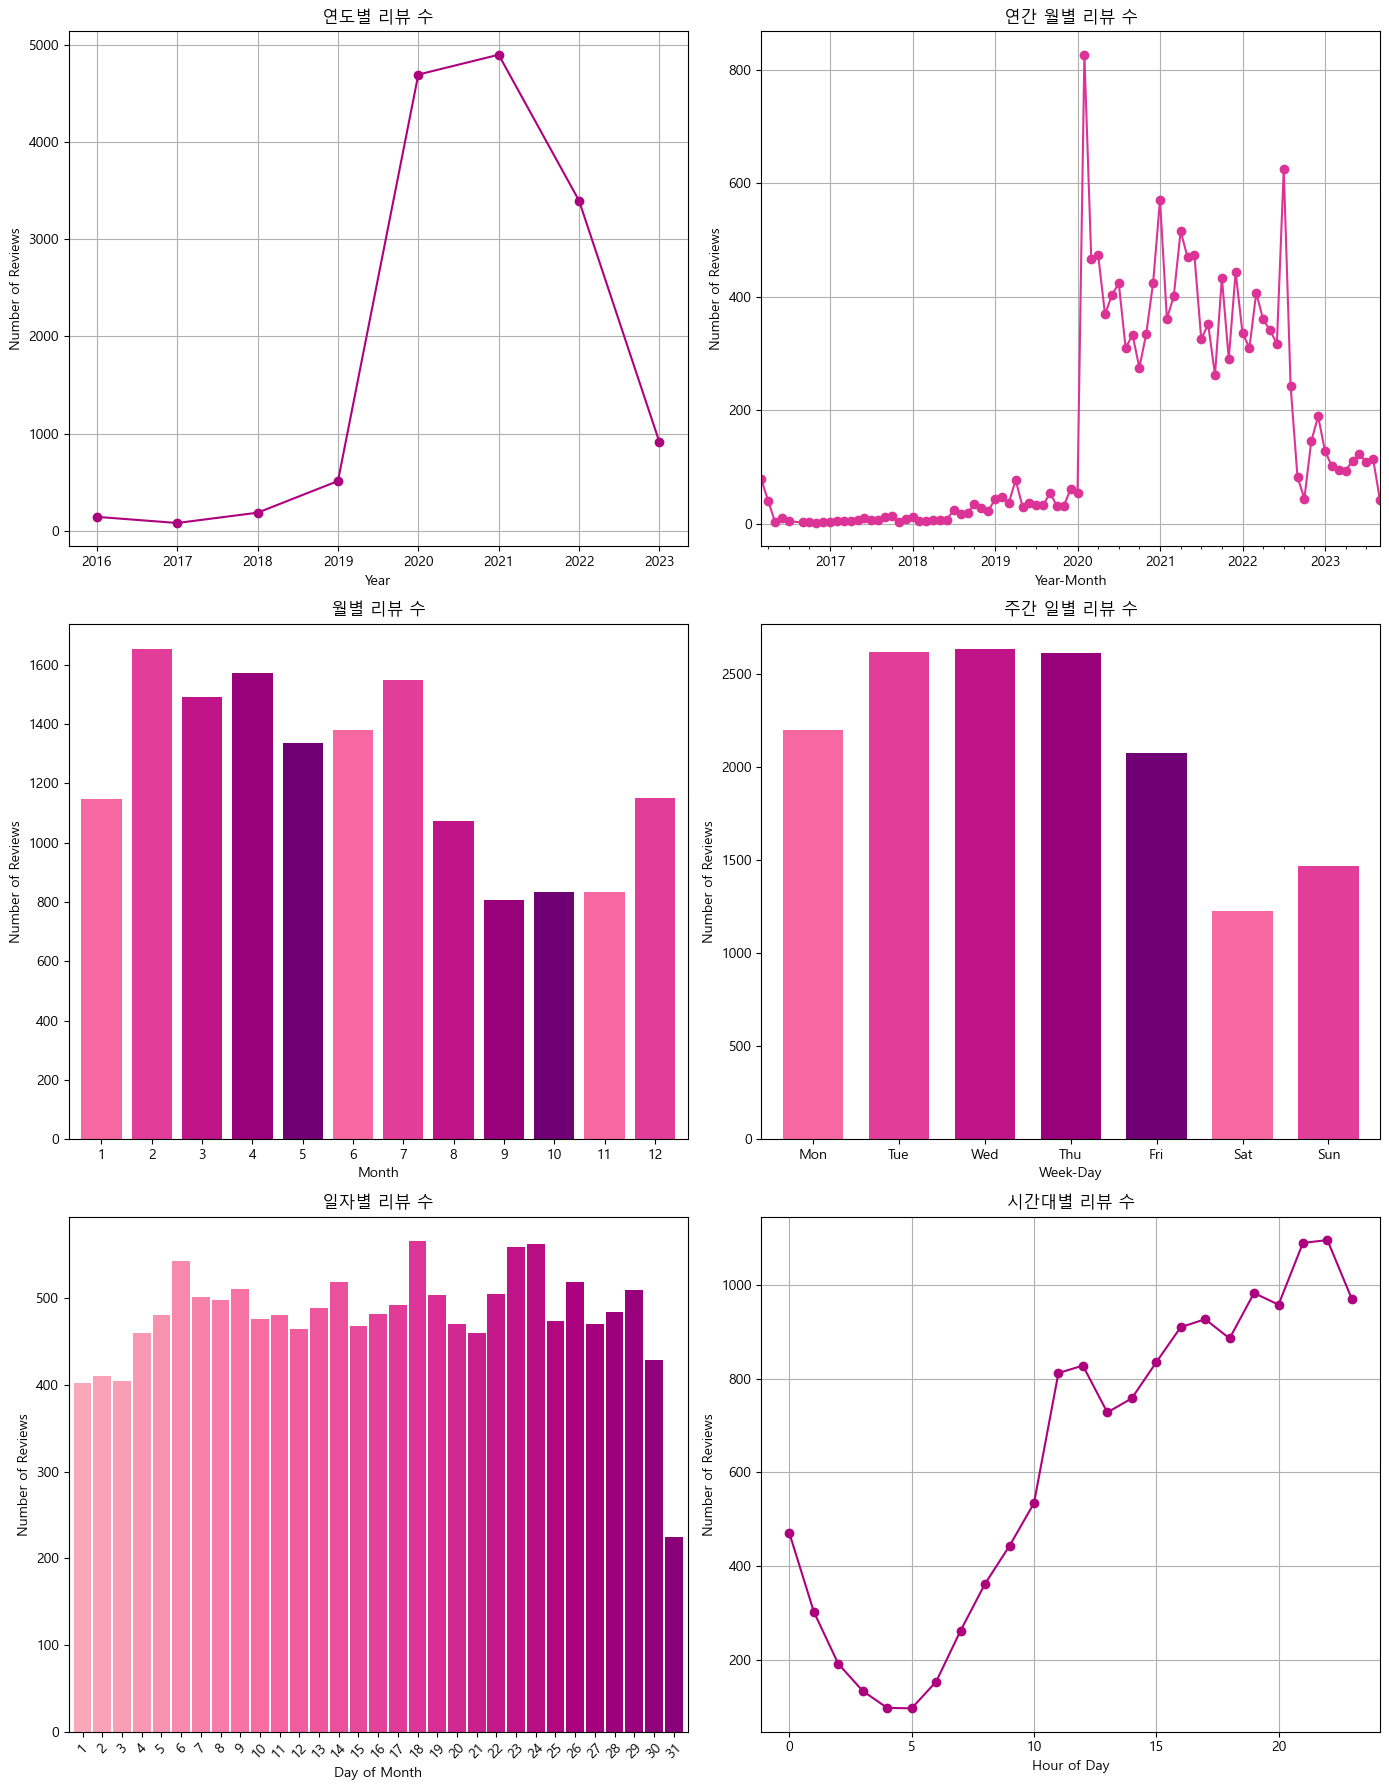

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

colors = sns.color_palette("RdPu", 7)

# 연도별 리뷰 수
df_review['year'].value_counts().sort_index().plot(ax=axes[0, 0], color=colors[5], kind='line', marker='o')
axes[0, 0].set_title('연도별 리뷰 수')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].grid(True)

# 연간 월별 리뷰 수
df_review['year_month'].value_counts().sort_index().plot(ax=axes[0, 1], color=colors[4], kind='line', marker='o')
axes[0, 1].set_title('연간 월별 리뷰 수')
axes[0, 1].set_xlabel('Year-Month')
axes[0, 1].set_ylabel('Number of Reviews')
axes[0, 1].grid(True)

# 월별 리뷰 수
df_review['month'].value_counts().sort_index().plot(ax=axes[1, 0], color=sns.color_palette("RdPu", 9)[4:], width=0.8, kind='bar')
axes[1, 0].set_title('월별 리뷰 수')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_xticks(ticks=range(12), labels=[str(i) for i in range(1, 13)], rotation=0)
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].grid(False)

# 주별 리뷰 수
df_review['week'].value_counts().sort_index().plot(ax=axes[1, 1], color=sns.color_palette("RdPu", 9)[4:], width=0.7, kind='bar')
axes[1, 1].set_title('주간 일별 리뷰 수')
axes[1, 1].set_xlabel('Week-Day')
axes[1, 1].set_xticks(ticks=range(7))
axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
axes[1, 1].set_ylabel('Number of Reviews')
axes[1, 1].grid(False)

# 일자별 리뷰 수
df_review['day'].value_counts().sort_index().plot(ax=axes[2, 0], color=sns.color_palette("RdPu", 60)[20:], width=0.9, kind='bar')
axes[2, 0].set_title('일자별 리뷰 수')
axes[2, 0].set_xlabel('Day of Month')
axes[2, 0].set_xticks(ticks=range(31), labels=[str(i) for i in range(1, 32)], rotation=45)
axes[2, 0].set_ylabel('Number of Reviews')
axes[2, 0].grid(False)

# 시간대별 리뷰 수
df_review['hour'].value_counts().sort_index().plot(ax=axes[2, 1], color=colors[5], kind='line', marker='o')
axes[2, 1].set_title('시간대별 리뷰 수')
axes[2, 1].set_xlabel('Hour of Day')
axes[2, 1].set_ylabel('Number of Reviews')
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()


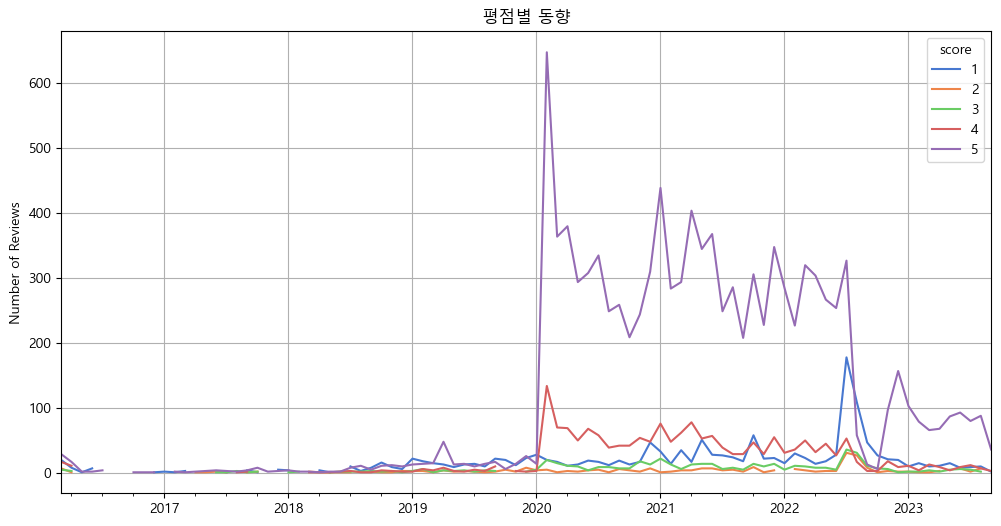

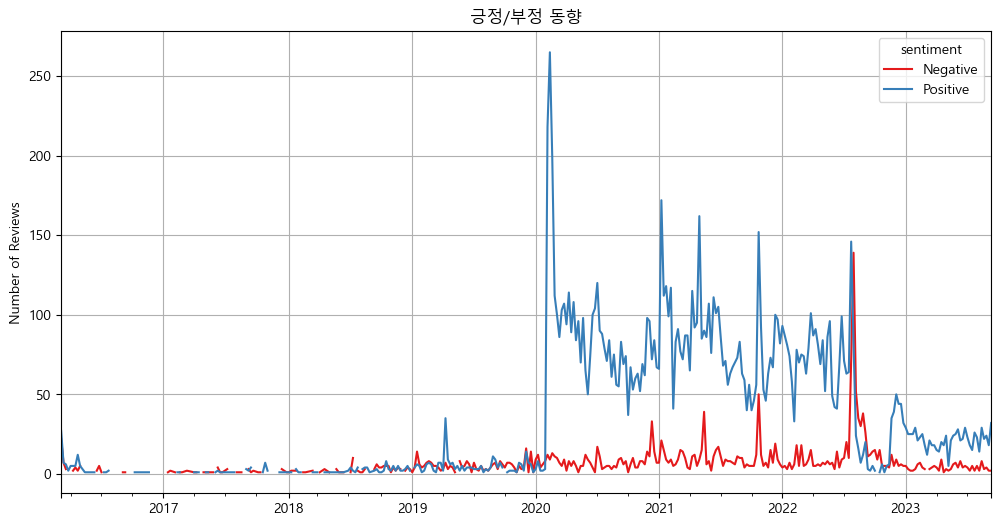

In [15]:
df_review.groupby([df_review['at'].dt.to_period("M"), 'score']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("muted", 5))
plt.title('평점별 동향')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

ax = df_review.groupby([df_review['at'].dt.to_period("W"), 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('긍정/부정 동향')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.grid(True)
# ax.axvspan('2020-01', '2023-01', facecolor='gray', alpha=0.1)
plt.show()


---

### 위 긍/부정 동향을 토대로 2020~2022년 중점 확인

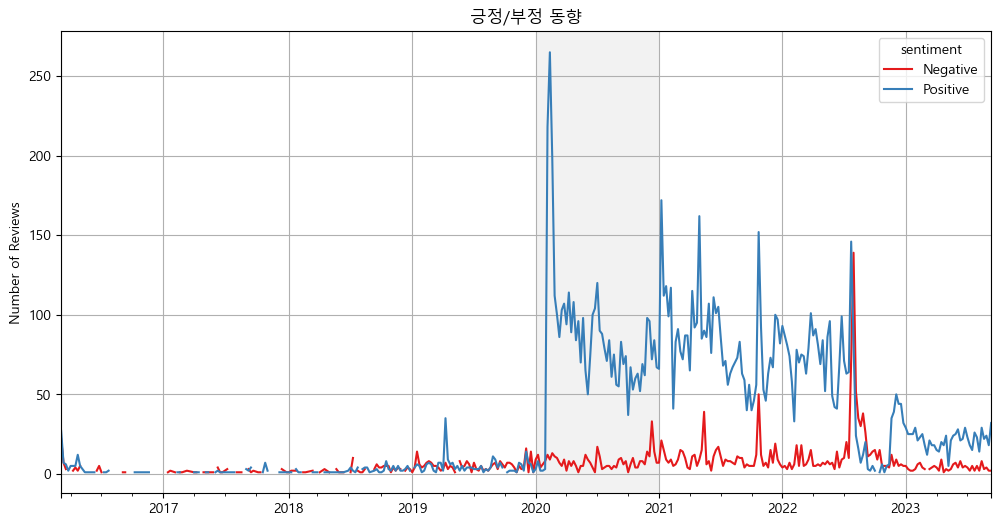

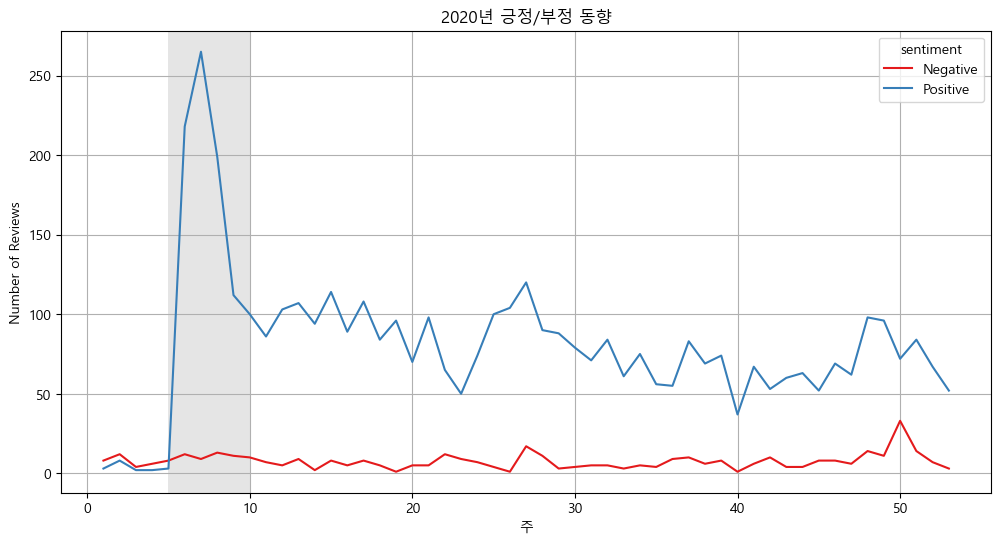

In [16]:
# 2020년
ax = df_review.groupby([df_review['at'].dt.to_period("W"), 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('긍정/부정 동향')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.grid(True)
ax.axvspan('2020-01', '2021-01', facecolor='gray', alpha=0.1)
plt.show()

df_2020 = df_review[df_review['at'].dt.year == 2020]
ax = df_2020.groupby([df_2020['at'].dt.week, 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('2020년 긍정/부정 동향')
plt.xlabel('주')
plt.ylabel('Number of Reviews')
plt.grid(True)
ax.axvspan(5, 10, facecolor='gray', alpha=0.2)
plt.show()

In [17]:
# 2020년 5~10주차 긍정리뷰 확인
df_2020[(df_2020['at'].dt.week >= 5) | (df_2020['at'].dt.week <= 10)  & (df_2020['score'] >= 4)][['content', 'appVersion']].sample(10)

,content,appVersion
13545,가격이 좀 내려가고 종류가 좀더 다양해진다면 더할나위 없을꺼 같아요,2.19.3
9468,"「 tt7788 」 장보는 것이 편리하긴하지만 샛별배송지역이 아니면 사고싶은 제품을 살 수 없는 점이 아쉽습니다. (일반적으로 택배로 받을 수 있는 제품이 샛별배송 온리인 경우) 차별화된 제품을 선보이는 것 또한 좋은 선택이지만, 타겟이 되는 소비층은 일부지역에 한정되어 있다는 게 아쉬워요. 하루아침에 시스템을 변화시키기엔 어려움이 있는 것을 인지하지 못하는 것은 아니나 다른 경쟁업체에 비해 느리다는 느낌이 강합니다.",2.23.2
10495,코로나19 로 마트 가는것도 무서운데 주문하면 바로 담날 눈뜨면 배송되니 이보다 좋을수가~ ^^,2.21.2
11045,바로 새벽배송이되서 너무 좋아요~ 다양하게 더 많은 제품이 생겼으면 좋겠어요:),2.21.0
13544,밤11시전에 주문하면 몇시간후 새벽에 도착~바로 주문해서 담날 요리해서 먹으니 더 맛있어요,2.19.3
12411,좋아요,2.19.4
11147,가격은 장난없지만 물건종류가 메리트 있음,2.21.0
12510,요즘같은때 꼭 필요한앱!,2.19.4
10652,모든게 아주 편리하게 잘되어있어서 정말좋아요.,2.21.2
13343,가입하고 여러분 주문했어요 편하고 좋아요,2.19.3


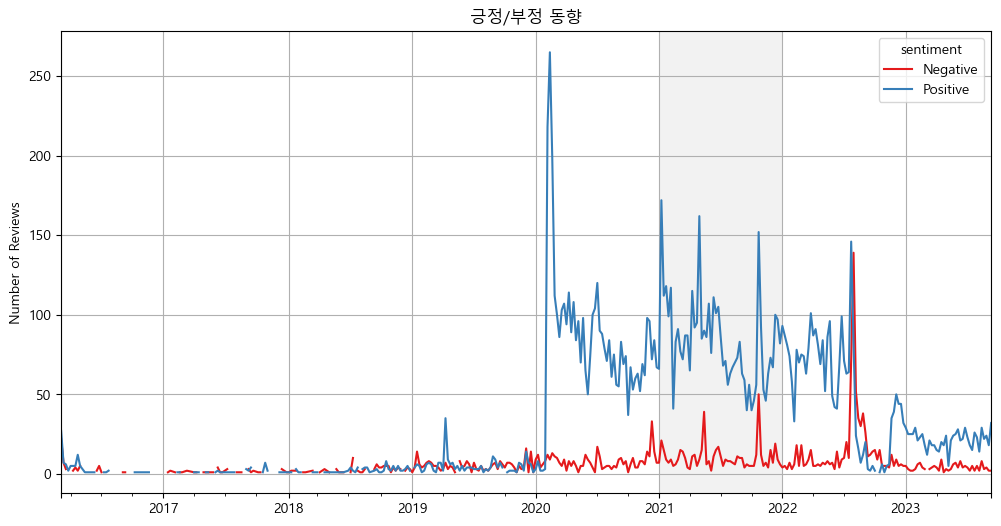

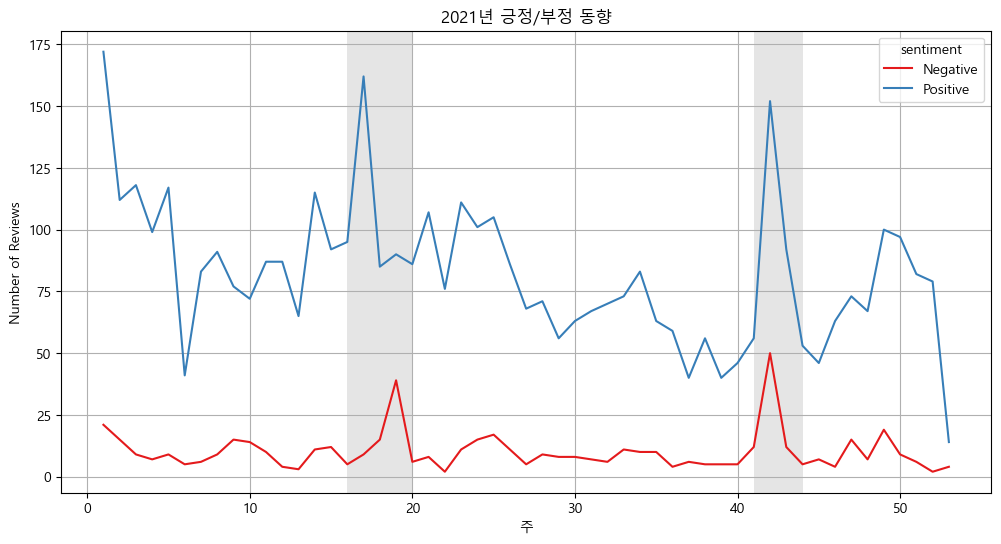

In [18]:
# 2021년
ax = df_review.groupby([df_review['at'].dt.to_period("W"), 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('긍정/부정 동향')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.grid(True)
ax.axvspan('2021-01', '2022-01', facecolor='gray', alpha=0.1)
plt.show()

df_2021 = df_review[df_review['at'].dt.year == 2021]
ax = df_2021.groupby([df_2021['at'].dt.week, 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('2021년 긍정/부정 동향')
plt.xlabel('주')
plt.ylabel('Number of Reviews')
plt.grid(True)
ax.axvspan(16, 20, facecolor='gray', alpha=0.2)
ax.axvspan(41, 44, facecolor='gray', alpha=0.2)
plt.show()

In [19]:
# 2021년 16~18주차 긍정리뷰 확인
df_2021[((df_2021['at'].dt.week >= 16) | (df_2021['at'].dt.week <= 18))  & (df_2021['score'] > 3)][['content', 'appVersion']].sample(10)

,content,appVersion
4393,조아용,2.36.4
6169,좋아요,2.32.0
8516,너무 잘쓰고있어요,2.24.0
6618,좋아요 배송도 빠르고,2.30.0
5429,제품을 시켜보니 확실히 검토를 하고 판매를 하는거 같아요~,2.34.0
7741,배송 빠르고 포장 좋고 제품 좋네요,2.27.0
4320,이벤트별로 정리가 잘 되어있음,2.37.0
7280,굿입니다,2.28.0
4662,항상 신선한 식품 구입 잘하고 있어요,2.36.1
8703,앱도 깔끔하고 좋은데 찜이나 좋아요 기능처럼 다음에 사려고 저장해놓을 수 있는게 생겼으면 좋겠어요,2.24.0


In [20]:
# 2021년 17~19주차 부정리뷰 확인
df_2021[((df_2021['at'].dt.week >= 17) | (df_2021['at'].dt.week <= 19))  & (df_2021['score'] <= 3)][['content', 'appVersion']].sample(10)

,content,appVersion
7296,업데이트 안됨,2.27.0
8165,사람갈아 돈 벌지 마세요,2.26.0
9165,에러가 많이 발생함,2.24.0
7136,"주말 택배쉰다고 주문도 안받는건 처음본다. 이럴거면 주말주문불가라고 대문짝만하게 적어놓던가ㅋㅋㅋ 이것도 월요일에나 확인 하시것지. 행사 15일 까지로 적어놓고 마지막날에는 주문 안받아버리기~ 엌ㅋㅋㅋㅋㅋ 밑에 리뷰들 주욱 읽어 보니까 택배안되면 주문도 안받음 이러는거 같은데 어떤 쇼핑몰이 택배쉰다고 주문도 쉬어ㅋㅋㅋ 주문은 받고 지연된다고 하지ㅋㅋㅋㅋㅋ 이러면 소비자 입장에서는 그냥 쿠폰이나 행사 상품 기간 줄이기로 밖에 안 보이잖아 이건ㅋㅋㅋㅋ 와, 대응들도 소비자들이 이해해주세요 수준으로 적어 놨어ㅋㅋㅋㅋ 쿠팡이나 ssg에 비해서 좋은게 없네요ㅋ 와, 찾아 보니까 논란도 많네 이 사업 원금회수는 하겠냐ㅋㅋㅋㅋㅋ 개선의지가 있는 직원 따돌리는 현장부터 노동법위반에 위생 논란도 있었네? 근데 대응은 뭐 이리 대충이야 망하는 길밖에 안보인다. 첫주문 하고 괜찮은거 같아서 주변에 추천 하려다 쓰지말라고 말하고 다녀할 수준으로 보이게 만드는 놀라운 경영 잘보고 갑니다~ ^^",2.29.0
7143,구려,2.24.0
8505,구글통해서만 꼭 가능한지요,2.24.0
8153,최악이네요^^,2.26.0
7709,100원 이벤트... 물건 하나사야지 할수 있어요.. 나처럼 낚여서 가입하지 마시길..,NaN
4596,"5000, 5000 포인트가 오지 않는 까닭은?",2.36.2
5700,"과일류는 정말 최악인 마켓 (캠벨포도는 다, 시들어있고..방울토마토는 중간중간 쭈글쭈글 시들은거 끼워넣기..과일류는 웬만하면 반품이 힘들다는걸 알고 이런 짓거리를 ..우리동네 나들가게도 이보단 싱싱하다...나..참..)",2.34.0


In [21]:
# 2021년 41~43주차 긍정리뷰 확인
df_2021[((df_2021['at'].dt.week >= 41) | (df_2021['at'].dt.week <= 43))  & (df_2021['score'] > 3)][['content', 'appVersion']].sample(10)

,content,appVersion
5928,시골인데 쿠땡보다 빨라서 좋아요,2.33.0
6450,배송도빠르고 믿을만해요,2.31.1
6710,특별한 식자재나 간편조리식구매하기괜찮습니다. 품목이더다양해지면좋겠네요,2.30.0
7528,관심상품이나 찜 기능이 생겼으면 좋겠습니다! 검색하다 좋은 상품이 있어도 찜 기능이 없어서 장바구니에 넣어두는 방법밖에는 없더라고요ㅠㅠ,2.27.0
7943,편하네요,2.26.0
4746,간편하게~할인까지 집에서 장보기!!!,NaN
7457,좋아요 ㅎㅎ 할인율도 좋고 쿠폰 이벤트 연락도 잘오고 혜택도 커서 지울수가 없는 어플입니다,2.28.0
5860,추천템...아주 좋와요!,2.33.0
4542,깐깐하고 스마트한 먹거리 쇼핑이 가능. 쿠폰 선물을 놓치지 않는 ㅎㅎ,2.36.3
6343,완전 좋아요,2.30.0


In [22]:
# 2021년 41~43주차 부정리뷰 확인
df_2021[((df_2021['at'].dt.week >= 41) | (df_2021['at'].dt.week <= 43))  & (df_2021['score'] <= 3)][['content', 'appVersion']].sample(10)

,content,appVersion
4702,업데이트 하라고 구글 보내고 구글에서는 앱 열라고 하고 어쩌라는 건지...,2.36.0
5163,아이디 찾기를 할 때 카카오톡에 문의를 달라는데 회원 아이디를 모르는데 무슨 문의를 하라는거에요,2.35.2
5166,업데이트 후 장바구니 열리지도 않고 주문 포기. 앱 삭제 후 다시 설치해도 동작 안 됨.,2.35.2
7231,아니... 카카오 페이지에서 회원가입 하면 1000캐시 준다해서 회원가입 끝냈는데 왜 안 들어오죠?,2.28.0
6400,결제시 오류... ㅡㅡ,2.31.1
5021,택배 주문을 할 려고 했는데 할때안되네요.,NaN
9165,에러가 많이 발생함,2.24.0
4651,로그인불가,2.36.1
4980,동일 서비스 쿠팡보다 못하고 가격은 스마일배송이 더싸고 쿠폰도 많이줌. PB상품도 딱히 저렴하지도 맛있지도 않음.,2.35.2
5204,오류 심각했어요,2.35.2


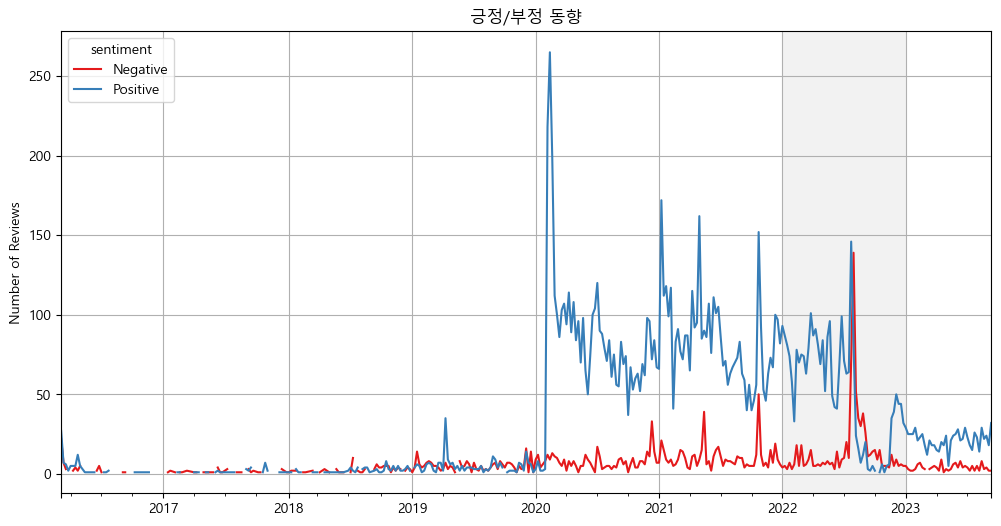

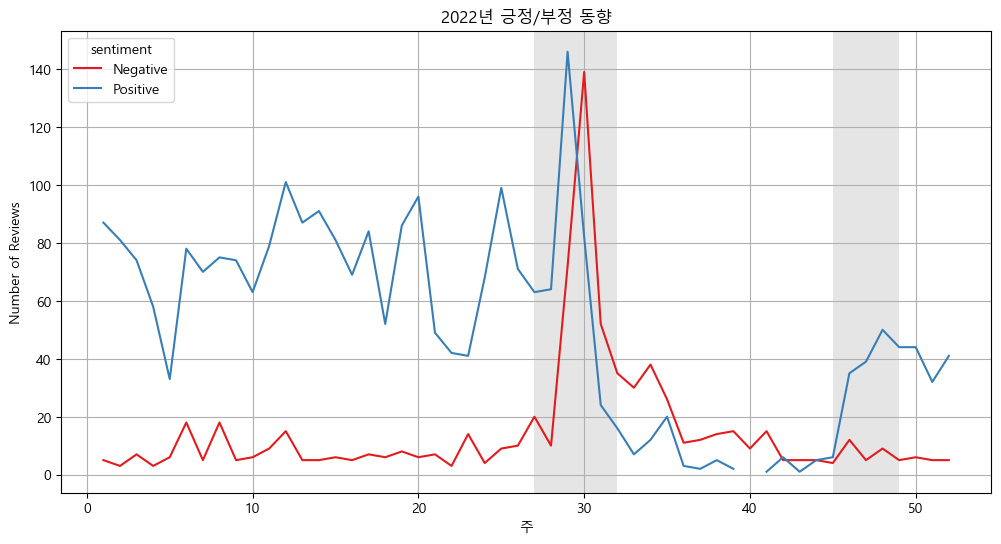

In [23]:
# 2022년
ax = df_review.groupby([df_review['at'].dt.to_period("W"), 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('긍정/부정 동향')
plt.xlabel('')
plt.ylabel('Number of Reviews')
plt.grid(True)
ax.axvspan('2022-01', '2023-01', facecolor='gray', alpha=0.1)
plt.show()

df_2022 = df_review[df_review['at'].dt.year == 2022]
ax = df_2022.groupby([df_2022['at'].dt.week, 'sentiment']).size().unstack().plot(figsize=(12, 6), color=sns.color_palette("Set1", 2))
plt.title('2022년 긍정/부정 동향')
plt.xlabel('주')
plt.ylabel('Number of Reviews')
plt.grid(True)
ax.axvspan(27, 32, facecolor='gray', alpha=0.2)
ax.axvspan(45, 49, facecolor='gray', alpha=0.2)
plt.show()

In [24]:
# 2022년 27~29주차 긍정리뷰
df_2022[(df_2022['at'].dt.week >= 27) | (df_2022['at'].dt.week <= 29)  & (df_2022['score'] >= 4)][['content', 'appVersion']].sample(10)

,content,appVersion
4057,굿굿굿,2.36.4
3993,신선한품질 빠른 배송,2.36.4
1395,이것도 앱이라고..업뎃후 주문이 안되네요. 자사 망하라는 앱인가여?,NaN
3321,아침에 똑배송. 신선하고 포장도 꼼꼼. 친환경이라 만족해요.,2.38.3
2352,신속하고 친절하고 상품 가성비도 만족합니다~,2.40.0
2445,좋아요,2.39.2
2808,마켓컬리 좋아요~~,2.39.0
1237,제품의신뢰성이 갑니다,2.40.1
1663,"업데이트후 적립가능후기들이 사라졌습니다. 몰아서 후기쓰려고 했는데, 최근 구입한것 빼고 다사라졌습니다. 적립가능일이 6일 못되게 남았었는데 1대1문의 하고 이틀후 연락이 와서 이제 4일 남았습니다. 업데이트오류로 적립금이 안보일수있다고 pc나 모바일웹으로는 보인다고 합니다. 모르는사람들은 적립가능일이 얼마안남은 분들은 적립도 못하고 넘어갈수도 있습니다. 백원 푼돈이지만 피해발생가능한데 긴급공지도 안해주고 애용자지만 불쾌합니다 덧붙여 다른날 씁니다.... 이제는 되겠지 하고 1대일 답변 대로 피씨나 웹으로 접속하면 된다해서 웹으로 접수했는데도 오류가 뜨네요. 물건을 배송받았는데도 배송받지 않은 물건은 적립후기 쓸수없다고 뜨고. 1일남은 후기는 같은 오류로 써지지도 않아요. . . 방금은 1일남은 후기 2일남은 후기가 지워졌어요. . . 아예 쓸수가 없게 지워졌네요. . . 신뢰할수가 없습니다. 거의 매일 시키는 마켓컬리.. 언제까지 성의 없게 죄송합니다.업데이트오류로.할껀지",3.0.1
3753,ㅎㅋ 빠른배송 아주 좋아용,2.38.2


In [25]:
# 2022년 30주차 부정리뷰 
df_2022[(df_2022['at'].dt.week == 30) & (df_2022['score'] <= 3)][['content', 'appVersion']].sample(10)

,content,appVersion
1752,업데이트하고삭제해도 오류뜨고 너무 불편하네요,2.41.2
1657,종류가 아직 다양하지 않아서 몇가지 밖에 이용을 못하고 있습니다,3.0.1
1724,"잘 사용하고 있었는데 업데이트 이후 장바구니에 담아둔 물건확인이 안됩니다..ㅠ 메인화면 상단 장바구니 모양에는 분명 제가 넣은 물건수만큼 숫자가 있는걸 확인할 수 있는데, 장바구니를 눌러 들어가보면 장바구니에 담긴 상품이 없다고 뜨네요ㅠㅠ",2.41.3
1704,업데이트 후 지속적으로 일시적인 장애가 발생했다며 결제진행이 되질 않습니다.,3.0.0
1702,대체 이 오류문제들 언제 정상화되나요? 장바구니에 물건은 담겼는데 보이지도않고 업뎃했는데도 소용없어요. 홈페이지에 무슨 안내든 사과문이든 띄어야하시는거 아닙니까! 고객들에 대한 배려도 없으시고 우선순위를 좀 두고 일처리하시는것이.. 당황스럽고 고객센터 통해 또 응대를 기다려야하고..,3.0.0
1645,"업그레이드 이후, 장바구니에 담아도 삭제되거나 오른쪽상단 장바구니그림에 숫자가 표기되어있음에도 장바구니로 들어가면 비어있다고 나와 주문을 못하고 있습니다. 빠른 조치 부탁드립니다.",3.0.1
1802,로그인이 되어잇는데 왜 로그인하라고 그러는거져 장바구니에 담아놓은거 계속사라지는데 물건을 사라는거에여 말라는건가요ㅡㅡ,2.41.2
1764,오늘 계속 어플 나갔다오면 로그아웃이 되있네요 ㅜㅜ,2.41.2
1676,잘쓰던 앱이었는데 업데이트가 문제,2.41.3
1749,상세 페이지를 보려고만 하면 앱이 일시정지 멈췄다가 까만화면 그리고 꺼져버리네요. 몇일째 몇번째 반복되고 있는데 쇼핑을 그만하란 뜻인가요..... 몇년동안 멀쩡하던 앱이 그러는 이유는 모르겠지만 이글에 또 고객센터 연락하라는 답변 다시겠지요?,2.41.1


In [26]:
# 2022년 45~50주차 긍정리뷰
df_2022[(df_2022['at'].dt.week >= 45) | (df_2022['at'].dt.week <= 50)  & (df_2022['score'] >= 4)][['content', 'appVersion']].sample(10)

,content,appVersion
3253,만족합니다.,2.38.3
2696,쿠폰이 쇼핑하는데 많은 도움이되네요.^^,2.39.1
2461,상품 설명이 잘 되어있어요,2.39.2
2293,샛별배송과 소량포장 재료들 좋아요,2.40.1
2863,보기좋게 나열되어 있어 보기 좋아요,2.39.0
1059,소비자 기만하는 기업. 가입 전에는 품절 표시 없애서 가입 유도하고 가입해서 들어가면 품절 됐다고 뜸. 이런 기업은 개인적으로 보이콧함. 하나를 보면 열을 안다고 했음,3.6.2
935,좋아요,3.7.0
1615,zim999 마켓컬리 짱편하고 제품이 신선해서 좋아요^^여기는 지방인데 저는 주로 냉동식품이나 볶음밥 떡볶이 같은 간편식품 시키거든요. 많이 시키면 따로따로 포장되서 배송올때도 있는데 냉매제 포장해서 녹지않게 잘 오더라구요. 아주아주 만족하고 있어요. 마켓컬리 넘넘 편하고 좋아요^^,3.0.1
3685,제품에 믿음이가요~~♡,2.38.2
2708,편하고 싸고 경제적인 소비,2.39.0


* 2020년 5주차 이후 코로나로 인한 사용자 급증에 따른 리뷰수 증가
* 2021년 긍정리뷰는 주로 새벽배송, 할인, 쿠폰 등 (서비스Update 직후 할인쿠퐁 제공된 것으로 유추)
* 2021년 부정리뷰는 주로 업데이트 이후 어플 사용의 불편함.
* 2022년 30주차 내외 서비스 업데이트 후 어플 사용의 불편함.
* 2022년 45주차 이후, 11월 7일 '뷰티컬리' 정식런칭으로 각종 이벤트 시행

---

### 업데이트 시기 확인

In [27]:
# 앱버전 feature 수정/통합
import re

df_review['appVersion'] = df_review['appVersion'].astype(str)

replace_dict = {
    "23": "2.3.0",
    "24": "2.4.0",
    "27": "2.7.0",
    "28": "2.8.0",
    "30": "3.0.0",
    "31": "3.1.0"
}

df_review['appVersion'].replace(replace_dict, inplace=True)


def modify_version(version):
    return re.sub(r'(\.\d+)$', '.0', version)

df_review['appVersion'] = df_review['appVersion'].apply(modify_version)

In [28]:
print(len(df_review[df_review['appVersion']=='nan']))
print(len(df_review['appVersion'].unique()))
print(df_review['appVersion'].unique())

857
58
['3.17.0' '2.17.0' 'nan' '3.16.0' '3.10.0' '3.12.0' '3.13.0' '3.15.0'
 '3.6.0' '3.11.0' '3.14.0' '2.37.0' '3.2.0' '2.39.0' '3.7.0' '3.4.0'
 '3.9.0' '3.1.0' '3.8.0' '2.27.0' '2.38.0' '3.5.0' '3.3.0' '3.0.0'
 '2.40.0' '2.24.0' '2.34.0' '2.21.0' '2.41.0' '2.19.0' '2.36.0' '2.22.0'
 '2.30.0' '2.35.0' '2.16.0' '2.33.0' '2.32.0' '2.25.0' '2.15.0' '2.31.0'
 '2.26.0' '2.23.0' '2.29.0' '2.28.0' '2.6.0' '2.14.0' '2.13.0' '2.12.0'
 '2.20.0' '2.18.0' '2.11.0' '2.10.0' '2.9.0' '2.8.0' '2.7.0' '2.5.0'
 '2.4.0' '2.3.0']


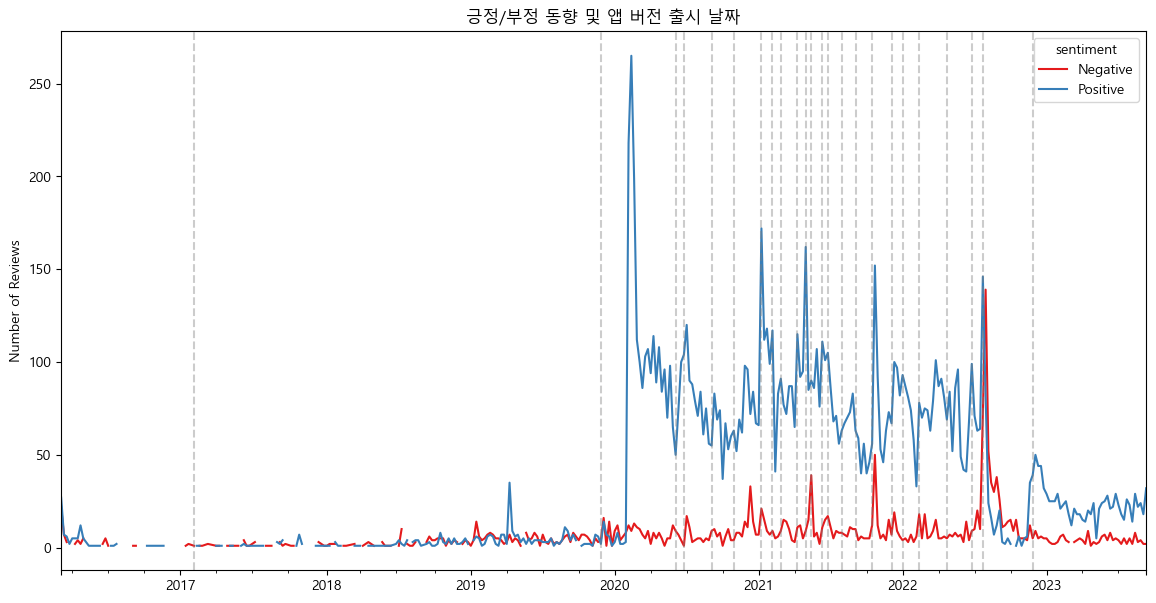

In [29]:
fig, ax = plt.subplots(figsize=(14, 7))

df_review.groupby([df_review['at'].dt.to_period("W"), 'sentiment']).size().unstack().plot(ax=ax, color=sns.color_palette("Set1", 2))
top_versions = df_review['appVersion'].value_counts().head(25).index
top_versions = [ver for ver in top_versions if ver != 'nan']

for version in top_versions:
    first_review_date = df_review[df_review['appVersion'] == version]['at'].min()
    ax.axvline(first_review_date, linestyle='--', alpha=0.4, color='gray')

ax.set_title('긍정/부정 동향 및 앱 버전 출시 날짜')
ax.set_xlabel('')
ax.set_ylabel('Number of Reviews')
plt.show()


---

### 리뷰 길이, 추천수 등

긍정 리뷰 평균 길이: 24.787835249042146
부정 리뷰 평균 길이: 72.04137630662021


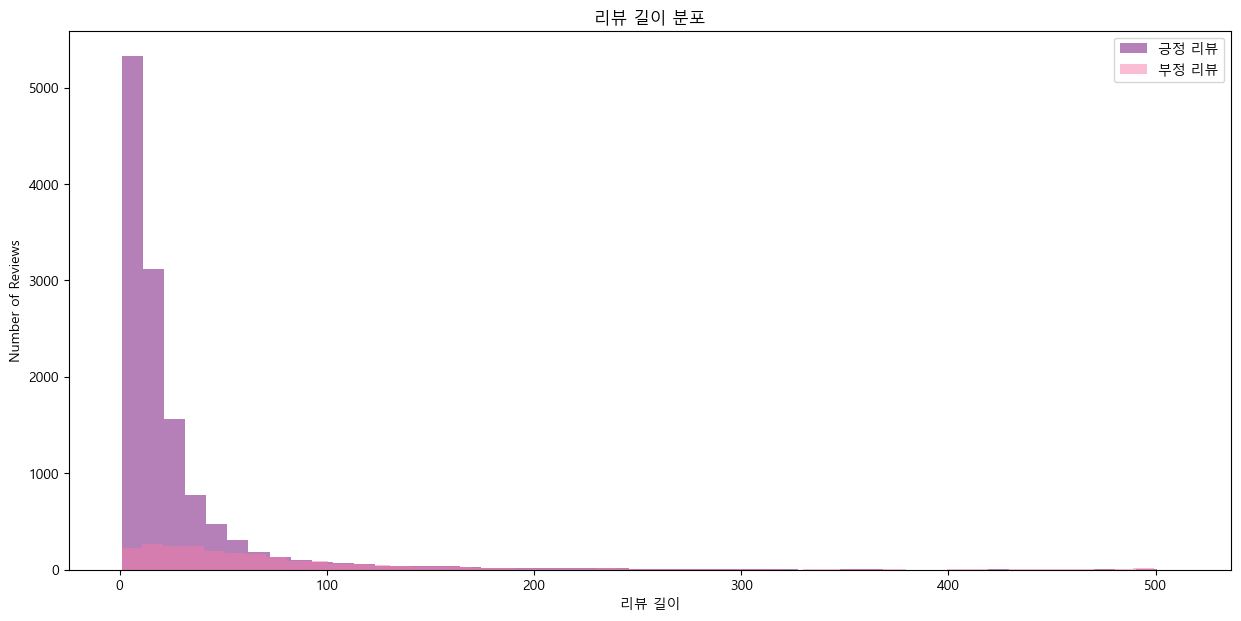

In [41]:
df_review['review_length'] = df_review['content'].apply(lambda x: len(str(x)))

positive_lengths = df_review[df_review['score'] >= 4]['review_length']
negative_lengths = df_review[df_review['score'] <= 3]['review_length']

print(f"긍정 리뷰 평균 길이: {positive_lengths.mean()}")
print(f"부정 리뷰 평균 길이: {negative_lengths.mean()}")

plt.figure(figsize=(15,7))
plt.hist(positive_lengths, bins=50, alpha=0.5, label='긍정 리뷰', color=sns.color_palette("RdPu", 10)[9])
plt.hist(negative_lengths, bins=50, alpha=0.5, label='부정 리뷰', color=sns.color_palette("RdPu", 10)[4])
plt.legend()
plt.xlabel('리뷰 길이')
plt.ylabel('Number of Reviews')
# plt.yscale('log')
plt.title('리뷰 길이 분포')
plt.show()

In [31]:
len(df_review[df_review['thumbsUpCount'] != 0])

1947

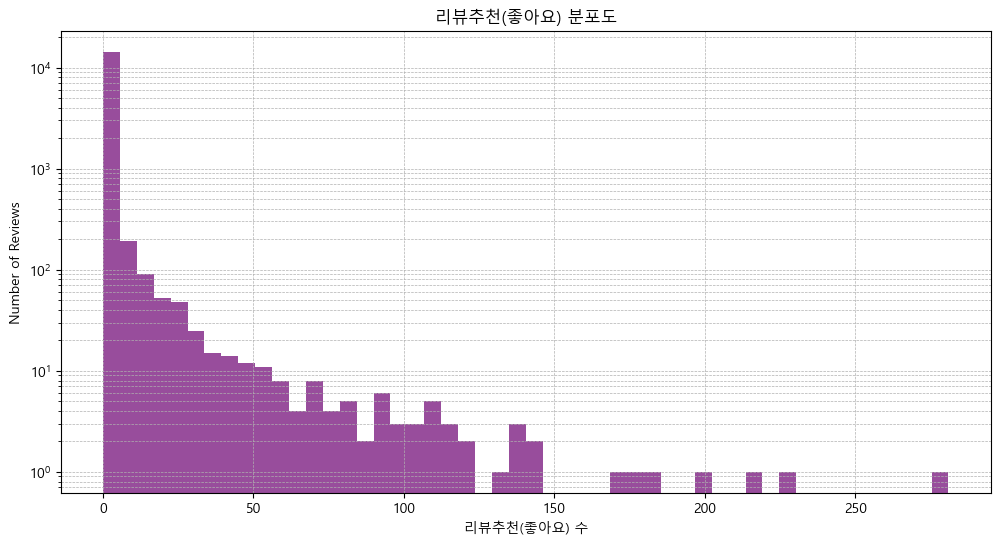

In [32]:
plt.figure(figsize=(12, 6))
plt.hist(df_review['thumbsUpCount'], bins=50, color=sns.color_palette("RdPu", 10)[9], alpha=0.7)
plt.title('리뷰추천(좋아요) 분포도')
plt.xlabel('리뷰추천(좋아요) 수')
plt.ylabel('Number of Reviews')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.show()

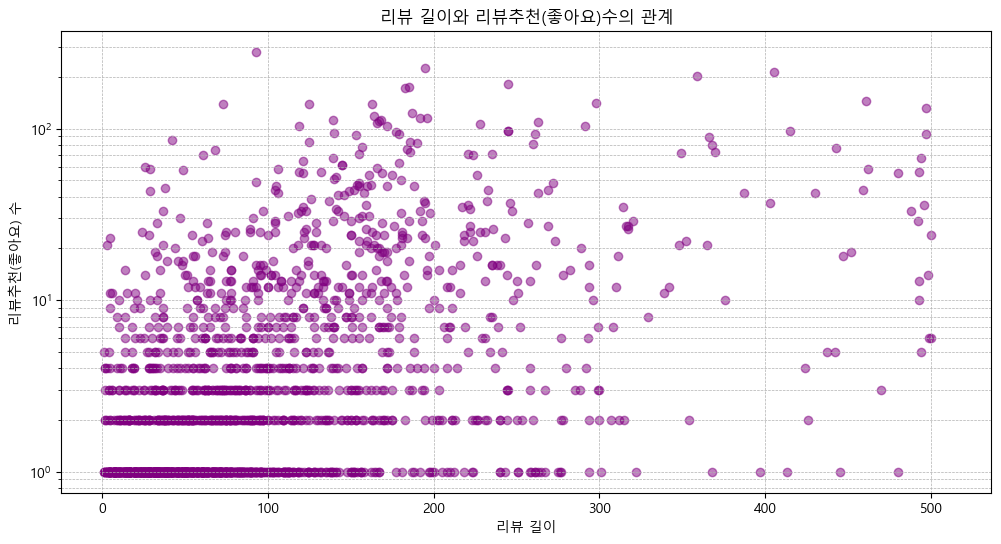

In [33]:
df_review['review_length'] = df_review['content'].str.len()

plt.figure(figsize=(12, 6))
plt.scatter(df_review['review_length'], df_review['thumbsUpCount'], alpha=0.5, color='purple')
plt.title('리뷰 길이와 리뷰추천(좋아요)수의 관계')
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰추천(좋아요) 수')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.show()


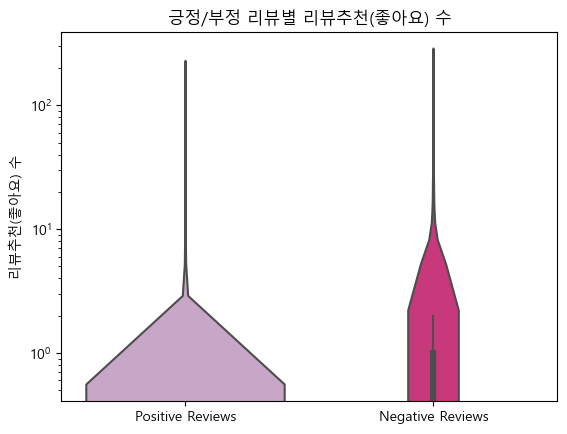

In [43]:
positive_reviews = df_review[df_review['score'] > 3]['thumbsUpCount']
negative_reviews = df_review[df_review['score'] <= 3]['thumbsUpCount']

sns.violinplot(data=[positive_reviews, negative_reviews], palette=sns.color_palette("PuRd", 2))
plt.xticks([0, 1], ['Positive Reviews', 'Negative Reviews'])
plt.ylabel('리뷰추천(좋아요) 수')
plt.yscale('log')
plt.title('긍정/부정 리뷰별 리뷰추천(좋아요) 수')
plt.show()

---

### 단골 고객 의견 파악

In [35]:
# 리뷰 작성 수 Top15 유저 추출
user_review_counts = df_review['userName'].value_counts()
print(user_review_counts.describe())
print('='*30)
print(user_review_counts.head(15))

count    10861.000000
mean         1.364884
std         26.449481
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       2757.000000
Name: userName, dtype: float64
Google 사용자    2757
이은정             14
김민정             11
김수진             11
김민지             10
김은정             10
이은주              9
김진희              9
김지현              8
김미경              8
김미숙              8
김동현              8
김경희              8
김은미              7
김지혜              7
Name: userName, dtype: int64


In [36]:
users_reviews = df_review.groupby('userName')['score'].apply(list).reset_index()
users_reviews['positive_count'] = users_reviews['score'].apply(lambda scores: sum([1 for s in scores if s > 3]))
users_reviews['negative_count'] = users_reviews['score'].apply(lambda scores: sum([1 for s in scores if s <= 3]))

top_users_names = user_review_counts.head(15).index
top_users = users_reviews[users_reviews['userName'].isin(top_users_names)]

top_users['positive_ratio'] = top_users['positive_count'] / (top_users['positive_count'] + top_users['negative_count'])
top_users['negative_ratio'] = 1 - top_users['positive_ratio']


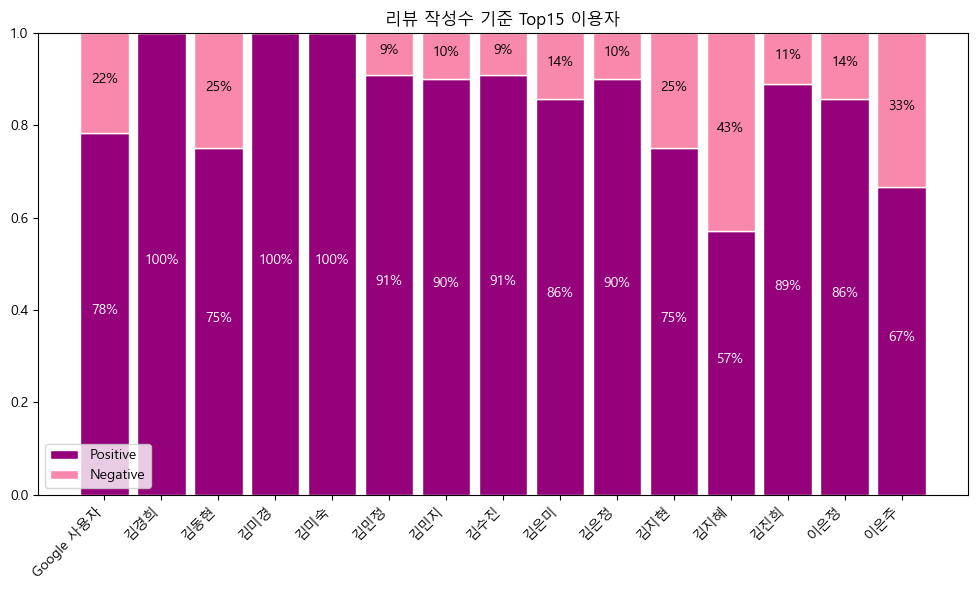

In [37]:
plt.figure(figsize=(12,6))
barWidth = 0.85
r = list(range(len(top_users)))

colors = sns.color_palette("RdPu", 20)

plt.bar(r, top_users['positive_ratio'], color=colors[16], edgecolor='white', width=barWidth, label='Positive')
plt.bar(r, top_users['negative_ratio'], bottom=top_users['positive_ratio'], color=colors[8], edgecolor='white', width=barWidth, label='Negative')

plt.xticks(r, top_users['userName'], rotation=45, ha='right')
plt.xlabel('')

# 바 중앙 % 표시
for i in r:
    positive_percentage = top_users['positive_ratio'].iloc[i]
    negative_percentage = top_users['negative_ratio'].iloc[i]
    
    if positive_percentage != 0:
        plt.text(i, positive_percentage / 2, "{:.0%}".format(positive_percentage), ha='center', color='white')
    if negative_percentage != 0:
        plt.text(i, positive_percentage + negative_percentage / 2, "{:.0%}".format(negative_percentage), ha='center')

plt.legend(loc='lower left')
plt.title('리뷰 작성수 기준 Top15 이용자')
plt.show()

In [38]:
df_review.loc[(df_review['userName'] == 'Google 사용자') & (df_review['score'] >= 4), ['userName', 'score', 'content']].sample(20)


,userName,score,content
14669,Google 사용자,5,100원이벤트로 오징어젓괄과 사과 구매했는데 진짜 짱 맛있어요. 새벽에 문앞에 놓고가시다니 완전 짱^^
12954,Google 사용자,4,좋아요.
12568,Google 사용자,5,새벽배송 너무좋아요! 초창기 마켓컬리는 제품이 너무없어서 앱깔았다 삭제했었는데 이제는 다양한 제품을 구매가능해서 좋네요ㅎ
13456,Google 사용자,5,만족합니다
13058,Google 사용자,5,경주인데 로켓배송이 안되어요 ㅠ 마켓컬리는 그래도 다음날오니까 좋아요
12541,Google 사용자,5,필요한 물건 금방 받아볼 수 있고 포장도 꼼꼼히 와서 좋아요 그리고 포인트도 금방 쌓여서 요긴하게 사용하고 있네요 :)
12612,Google 사용자,5,쉬워요
14777,Google 사용자,4,마켁컬리는 좋아하는 쇼핑몰안데 이번 앱 런칭하신거 축하드립니다. 다만 아직 막 개발해서 그런지 앱으로 몰 이용이 원활하진 않네요. 앱문제 보다는 서버쪽 문제인듯 ^^;; 지속적인 업뎃 부탁드립니다.
14353,Google 사용자,5,자취하면서 꼭 필요한 앱입니다 제품도 좋고 배송도 좋고
13043,Google 사용자,5,급할때 아주 편리하게 사용하고 있습니다.


In [39]:
df_review.loc[(df_review['userName'] == '김지혜') & (df_review['score'] <= 3), ['userName', 'score', 'content']]

,userName,score,content
404,김지혜,1,여러가지로 소통이 불편하고 앱 접속 등이 원활하지 않습니다
1353,김지혜,1,상품문의하기 버튼이 아무리 재설치 눌러도 안눌러져요!!!!
10056,김지혜,1,서울경기인천외 타지역은 배달자체를 안해주는 물품이많네요 괜히 깔았네요 배달도 안해주는데ㅠ


In [40]:
df_review.loc[(df_review['userName'] == '이은주') & (df_review['score'] <= 3), ['userName', 'score', 'content']]

,userName,score,content
1409,이은주,1,며칠째 주문 못함 장바구니에 담기면 모하냐구요 정작 살려고하면 비었다고 ㅠ 필요하니깐 새벽배송할려고 했던거죠 빨리 개선 부탁해요
5471,이은주,1,손쉽게 쇼핑해서 매일아침 신선한 재료의 상품을 만나니 넘 좋네요
6509,이은주,3,필터기능이 상세했으면 좋겠는데... 상품이 점점 많아지니 검색어로 들어가면 원하는 제품을 찾기까지 시간이 많이걸려서... 시간 아깝다는 생각에 이용을 잘 안하게 됩니다. 쿠팡이나 오케이 아웃도어 참고하셔서 고객여정 개선해주세요.


---